2018 / 1 / 30-31

Wayne Nixalo

# RetinaNet Finetuning -- Dev 3

In [111]:
import keras
import keras.preprocessing.image

# import keras_retinanet.losses
# import keras_retinanet.layers
from keras_retinanet.preprocessing.csv_generator import CSVGenerator
# from keras_retinanet.callbacks import RedirectModel
# from keras_retinanet.models.resnet import ResNet50RetinaNet
# from keras_retinanet.utils.keras_version import check_keras_version
from keras_retinanet.utils.image import preprocess_image, resize_image
from keras_retinanet.models.resnet import custom_objects # <-- what do I need this for?

import tensorflow as tf

import numpy as np
import os

In [112]:
def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

In [113]:
istg_data_path = 'data/interstage_train/'

In [114]:
keras.backend.tensorflow_backend.set_session(get_session())

model = keras.models.load_model('data/retinanet-model/resnet50_coco_best_v1.2.2.h5',
                                    custom_objects=custom_objects)

/home/wnixalo/miniconda3/envs/aersu/lib/python3.6/site-packages/keras/models.py:271: UserWarning: Output "non_maximum_suppression_2" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "non_maximum_suppression_2" during training.
  sample_weight_mode=sample_weight_mode)


In [115]:
# image data generator object to pass into CSVGenerator
image_gen = keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True)

```
Init signature: keras.preprocessing.image.ImageDataGenerator(featurewise_center=False, samplewise_center=False, featurewise_std_normalization=False, samplewise_std_normalization=False, zca_whitening=False, zca_epsilon=1e-06, rotation_range=0.0, width_shift_range=0.0, height_shift_range=0.0, shear_range=0.0, zoom_range=0.0, channel_shift_range=0.0, fill_mode='nearest', cval=0.0, horizontal_flip=False, vertical_flip=False, rescale=None, preprocessing_function=None, data_format=None)
Docstring:     
Generate minibatches of image data with real-time data augmentation.
```

Alright now I need to find out what exactly it wants in a `csv_data_file` and a `csv_class_file`. I'm guessing ..data_file is paths and ..class_file are the bbx coords. Annoying, but easy enough to write a script to convert my interstage_labels CSV file into two compatible CSVs. But need to check the [RetinaNet Github](https://github.com/fizyr/keras-retinanet/blob/master/keras_retinanet/preprocessing/csv_generator.py#L164:16) first to check. Actually the [Boring Detector](https://github.com/lexfridman/boring-detector/blob/master/train.py#L39:12) has an implementation qualitatively identical to mine (use retnet for new dataset for 1/0 class) so I should look there.

Okay.. what is `'boring-dataset'` in line 29 in [boring-detector/train.py](https://github.com/lexfridman/boring-detector/blob/master/train.py#L29:59)? Please tell me it's not a CSV file of ... images? If it's a file and not a path... how were the files packaged together? How can I *not* do that, and instead use my existing directory structure.. this is a headache.

Okay. Beautiful. From [keras-retinanet/keras_retinanet/preprocessing/csv_generator.py](https://github.com/fizyr/keras-retinanet/blob/master/keras_retinanet/preprocessing/csv_generator.py#L109:9):

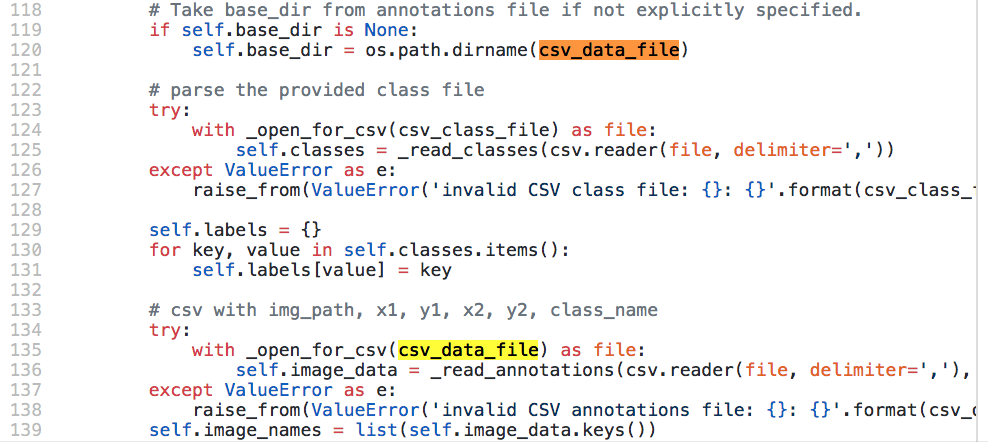

`csv_data_file` just contains `img_path, x1, y1, x2, y2, class_name`. But what's the purpose of including `class_name` if you also have an entire `csv_class_file` dedicated to it?

Ohhhhhhh. Okay. Retinanet is made to detect multiple classes in an image. `csv_class_file` contains that list of possible classes. The `csv_data_file` just lists which class a particular bounding box detection in some image happened to be.

This means if want to use RetinaNet's stock CSVGenerator - without rewriting it to accept my CSVs directly - I have to convert my CSV to be like `csv_data_file` and have a 2nd CSV just containing the classes I want to detect (just pilot). Alrighty then.

In [ ]:
datagen = CSVGenerator(csv_data_file='data/interstage_labels.csv',
                       csv_class_file)

```
Init signature: CSVGenerator(csv_data_file, csv_class_file, image_data_generator, base_dir=None, **kwargs)
```

## Converting the CSV

In [4]:
import pandas as pd
import numpy as np
import os

In [50]:
df = pd.read_csv('data/interstage_labels.csv')

In [51]:
df.head()

,id,gloc,x1,y1,x2,y2
0,000000-000412/000000,0,83,72,191,380
1,000000-000412/000001,0,52,89,204,381
2,000000-000412/000002,0,58,89,208,390
3,000000-000412/000003,0,66,98,214,388
4,000000-000412/000004,0,65,90,209,389


In [52]:
df_mat = df.as_matrix()

In [53]:
ids = df_mat[:,0]
x1  = df_mat[:,2]
y1  = df_mat[:,3]
x2  = df_mat[:,4]
y2  = df_mat[:,5]
# index 1 is gloc
cnames = ['pilot' for i in range(len(ids))]

In [54]:
ids

array(['000000-000412/000000', '000000-000412/000001',
       '000000-000412/000002', ..., '007365-007636/007634',
       '007365-007636/007635', '007365-007636/007636'], dtype=object)

In [55]:
for i in range(len(ids)):
    ids[i] = 'data/interstage_train/' + ids[i] + '.jpg'

In [56]:
ids

array(['data/interstage_train/000000-000412/000000.jpg',
       'data/interstage_train/000000-000412/000001.jpg',
       'data/interstage_train/000000-000412/000002.jpg', ...,
       'data/interstage_train/007365-007636/007634.jpg',
       'data/interstage_train/007365-007636/007635.jpg',
       'data/interstage_train/007365-007636/007636.jpg'], dtype=object)

In [57]:
dat = [ids,x1,y1,x2,y2]

for da in dat:
    print(da[:10])

['data/interstage_train/000000-000412/000000.jpg'
 'data/interstage_train/000000-000412/000001.jpg'
 'data/interstage_train/000000-000412/000002.jpg'
 'data/interstage_train/000000-000412/000003.jpg'
 'data/interstage_train/000000-000412/000004.jpg'
 'data/interstage_train/000000-000412/000005.jpg'
 'data/interstage_train/000000-000412/000006.jpg'
 'data/interstage_train/000000-000412/000007.jpg'
 'data/interstage_train/000000-000412/000008.jpg'
 'data/interstage_train/000000-000412/000009.jpg']
[83 52 58 66 65 50 51 49 48 91]
[72 89 89 98 90 73 74 75 71 97]
[191 204 208 214 209 208 197 200 203 201]
[380 381 390 388 389 386 382 381 376 376]


In [58]:
df = pd.DataFrame(ids, columns=['img_path'])
df.insert(1, 'x1', df_mat[:,2])
df.insert(2, 'y1', df_mat[:,3])
df.insert(3, 'x2', df_mat[:,4])
df.insert(4, 'y2', df_mat[:,5])
df.insert(5, 'class_name', cnames)

In [59]:
df.to_csv('data/interstage_retinanet_data.csv', index=False)

In [60]:
df = pd.read_csv('data/interstage_retinanet_data.csv')
df.head()

,img_path,x1,y1,x2,y2,class_name
0,data/interstage_train/000000-000412/000000.jpg,83,72,191,380,pilot
1,data/interstage_train/000000-000412/000001.jpg,52,89,204,381,pilot
2,data/interstage_train/000000-000412/000002.jpg,58,89,208,390,pilot
3,data/interstage_train/000000-000412/000003.jpg,66,98,214,388,pilot
4,data/interstage_train/000000-000412/000004.jpg,65,90,209,389,pilot


In [61]:
type(df['x1'][0])

numpy.int64

Yaaay. Now for the classes CSV file.

## Classes CSV file

In [103]:
classes_df = pd.DataFrame([cnames[0]], columns=['class_name'])
classes_df.insert(1, 'class_id', [0])
# classes_df = pd.DataFrame([cnames[0]],columns=None)
# classes_df.insert(1, None, [0])

classes_df.to_csv('data/interstage_retinanet_classes.csv', index=False, header=False)

So either way above works as long as you specify `header=False` when saving the CSV to disk.

**NOTE**: same probably goes for the CSV data (annotations, ie: bounding box coordinates + class) file.

In [105]:
classes_df = pd.read_csv('data/interstage_retinanet_classes.csv')
classes_df.head()

,pilot,0


Let's see how this works. From https://github.com/fizyr/keras-retinanet/blob/master/keras_retinanet/preprocessing/csv_generator.py#L136:35

```
ValueError: line 0: format should be 'class_name,class_id'
```
Hmm okay.

In [101]:
import csv
csv_class_file = 'data/interstage_retinanet_classes.csv'
from six import raise_from

def _open_for_csv(path):
    """
    Open a file with flags suitable for csv.reader.
    """
    return open(path, 'r', newline='')
def _parse(value, function, fmt):
    """
    Parse a string into a value, and format a nice ValueError if it fails.
    
    Returns `function(value`)
    """
    try:
        return function(value)
    except ValueError as e:
        raise_from(ValueError(fmt.format(e)), None)
    
def _read_classes(csv_reader):
    result = {}
    for line, row in enumerate(csv_reader):
        try:
            class_name, class_id =  row
        except ValueError:
            raise_from(ValueError('line {}: format should be \'class_name,class_id\''.format(line)), None)
        class_id = _parse(class_id, int, 'line {}: malformed class ID: {{}}'.format(line))
        
        if class_name in result:
            raise ValueError('line {}: duplicate class name: \'{}\''.format(line, class_name))
        result[class_name] = class_id
    return result
    
# parse the provided class file
with _open_for_csv(csv_class_file) as file:
    classes = _read_classes(csv.reader(file, delimiter=','))

In [98]:
classes

{'pilot': 0}

Looks like I got it.

23:54 -- 27 JAN 2018

In [118]:
# removing column headers from annotation/data CSV file
df = pd.read_csv('data/interstage_retinanet_data.csv')
df.to_csv('data/interstage_retinanet_data.csv', index=False, header=False)

In [119]:
datagen = CSVGenerator(csv_data_file='data/interstage_retinanet_data.csv',
                       csv_class_file='data/interstage_retinanet_classes.csv',
                       image_data_generator=image_gen,
                       batch_size=1)

FileNotFoundError: [Errno 2] No such file or directory: 'data/data/interstage_train/000000-000412/000000.jpg'

Huh, when did I tell it to start from `data/`? Oh well.

### Fixing data CSV header issue

In [120]:
df = pd.read_csv('data/interstage_retinanet_data.csv')
# df.to_csv('data/interstage_retinanet_data.csv', index=False, header=False)
# for i,fpath in enumerate(df[''])

In [127]:
df.iloc[0]

data/interstage_train/000000-000412/000000.jpg    data/interstage_train/000000-000412/000001.jpg
83                                                                                            52
72                                                                                            89
191                                                                                          204
380                                                                                          381
pilot                                                                                      pilot
Name: 0, dtype: object

In [128]:
df.iloc[0][0]

'data/interstage_train/000000-000412/000001.jpg'

In [129]:
len(df)

7636

In [130]:
for i in range(len(df)):
    df.iloc[0][i] = df.iloc[0][i].split('data/')[-1]

/home/wnixalo/miniconda3/envs/aersu/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


AttributeError: 'numpy.int64' object has no attribute 'split'

In [138]:
df.iloc[0][1]

52

In [137]:
df.iloc[1][0]

'data/interstage_train/000000-000412/000002.jpg'

Oh. First index, not second.

In [139]:
df.iloc[0][0]

'data/interstage_train/000000-000412/000001.jpg'

Ohhh... but now the actual first row, containing `'data/interstage_train/000000-000412/000001.jpg'` is being treated as the header of the DataFrame. Oof that's annoying. Alright I'll checkout reading them as ndarrays, otherwise I'll just remake the CSV.

In [140]:
df_mat = df.as_matrix()

In [142]:
df_mat

array([['data/interstage_train/000000-000412/000001.jpg', 52, 89, 204,
        381, 'pilot'],
       ['data/interstage_train/000000-000412/000002.jpg', 58, 89, 208,
        390, 'pilot'],
       ['data/interstage_train/000000-000412/000003.jpg', 66, 98, 214,
        388, 'pilot'],
       ...,
       ['data/interstage_train/007365-007636/007634.jpg', 65, 69, 260,
        397, 'pilot'],
       ['data/interstage_train/007365-007636/007635.jpg', 69, 68, 255,
        396, 'pilot'],
       ['data/interstage_train/007365-007636/007636.jpg', 52, 53, 249,
        395, 'pilot']], dtype=object)

Ah it's not even there. Alright then. I could edit the headers, but nah.

In [144]:
df = pd.read_csv('data/interstage_labels.csv')
df_mat = df.as_matrix()

ids = df_mat[:,0]
x1  = df_mat[:,2]
y1  = df_mat[:,3]
x2  = df_mat[:,4]
y2  = df_mat[:,5]
# index 1 is gloc
cnames = ['pilot' for i in range(len(ids))]

for i in range(len(ids)):
    ids[i] = 'interstage_train/' + ids[i] + '.jpg'

df = pd.DataFrame(ids, columns=['img_path'])
df.insert(1, 'x1', df_mat[:,2])
df.insert(2, 'y1', df_mat[:,3])
df.insert(3, 'x2', df_mat[:,4])
df.insert(4, 'y2', df_mat[:,5])
df.insert(5, 'class_name', cnames)

df.to_csv('data/interstage_retinanet_data.csv', index=False, header=False)

In [145]:
df = pd.read_csv('data/interstage_retinanet_data.csv')

In [146]:
df.head()

,interstage_train/000000-000412/000000.jpg,83,72,191,380,pilot
0,interstage_train/000000-000412/000001.jpg,52,89,204,381,pilot
1,interstage_train/000000-000412/000002.jpg,58,89,208,390,pilot
2,interstage_train/000000-000412/000003.jpg,66,98,214,388,pilot
3,interstage_train/000000-000412/000004.jpg,65,90,209,389,pilot
4,interstage_train/000000-000412/000005.jpg,50,73,208,386,pilot


Looks good.

### 2nd attempt at data generator

In [147]:
datagen = CSVGenerator(csv_data_file='data/interstage_retinanet_data.csv',
                       csv_class_file='data/interstage_retinanet_classes.csv',
                       image_data_generator=image_gen,
                       batch_size=1)

In [152]:
model.fit_generator(generator = datagen,
                    steps_per_epoch = 1000, # eh?
                    epochs    = 1,
                    verbose   = 1,)

Epoch 1/1


InvalidArgumentError: Inputs to operation loss_1/classification_loss/Select_2 of type Select must have the same size and shape.  Input 0: [1,67995,1] != input 1: [1,67995,80]
	 [[Node: loss_1/classification_loss/Select_2 = Select[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"](loss_1/classification_loss/Equal, loss_1/classification_loss/sub_1, classification_1/concat)]]
	 [[Node: loss_1/regression_loss/Mean_2/_3247 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_9664_loss_1/regression_loss/Mean_2", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'loss_1/classification_loss/Select_2', defined at:
  File "/home/wnixalo/miniconda3/envs/aersu/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/wnixalo/miniconda3/envs/aersu/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/wnixalo/miniconda3/envs/aersu/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/wnixalo/miniconda3/envs/aersu/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/wnixalo/miniconda3/envs/aersu/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start
    self.io_loop.start()
  File "/home/wnixalo/miniconda3/envs/aersu/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/wnixalo/miniconda3/envs/aersu/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/wnixalo/miniconda3/envs/aersu/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/wnixalo/miniconda3/envs/aersu/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/wnixalo/miniconda3/envs/aersu/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/wnixalo/miniconda3/envs/aersu/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/wnixalo/miniconda3/envs/aersu/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/wnixalo/miniconda3/envs/aersu/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 281, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/wnixalo/miniconda3/envs/aersu/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 232, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/wnixalo/miniconda3/envs/aersu/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 397, in execute_request
    user_expressions, allow_stdin)
  File "/home/wnixalo/miniconda3/envs/aersu/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/wnixalo/miniconda3/envs/aersu/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/wnixalo/miniconda3/envs/aersu/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/wnixalo/miniconda3/envs/aersu/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/wnixalo/miniconda3/envs/aersu/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-114-bea1d5c1beda>", line 4, in <module>
    custom_objects=custom_objects)
  File "/home/wnixalo/miniconda3/envs/aersu/lib/python3.6/site-packages/keras/models.py", line 271, in load_model
    sample_weight_mode=sample_weight_mode)
  File "/home/wnixalo/miniconda3/envs/aersu/lib/python3.6/site-packages/keras/engine/training.py", line 860, in compile
    sample_weight, mask)
  File "/home/wnixalo/miniconda3/envs/aersu/lib/python3.6/site-packages/keras/engine/training.py", line 459, in weighted
    score_array = fn(y_true, y_pred)
  File "/home/wnixalo/miniconda3/envs/aersu/lib/python3.6/site-packages/keras_retinanet-0.0.1-py3.6.egg/keras_retinanet/losses.py", line 42, in _focal
    focal_weight = backend.where(keras.backend.equal(labels, 1), 1 - classification, classification)
  File "/home/wnixalo/miniconda3/envs/aersu/lib/python3.6/site-packages/keras_retinanet-0.0.1-py3.6.egg/keras_retinanet/backend/tensorflow_backend.py", line 46, in where
    return tensorflow.where(*args, **kwargs)
  File "/home/wnixalo/miniconda3/envs/aersu/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 2441, in where
    return gen_math_ops._select(condition=condition, t=x, e=y, name=name)
  File "/home/wnixalo/miniconda3/envs/aersu/lib/python3.6/site-packages/tensorflow/python/ops/gen_math_ops.py", line 3988, in _select
    "Select", condition=condition, t=t, e=e, name=name)
  File "/home/wnixalo/miniconda3/envs/aersu/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/wnixalo/miniconda3/envs/aersu/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/home/wnixalo/miniconda3/envs/aersu/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): Inputs to operation loss_1/classification_loss/Select_2 of type Select must have the same size and shape.  Input 0: [1,67995,1] != input 1: [1,67995,80]
	 [[Node: loss_1/classification_loss/Select_2 = Select[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"](loss_1/classification_loss/Equal, loss_1/classification_loss/sub_1, classification_1/concat)]]
	 [[Node: loss_1/regression_loss/Mean_2/_3247 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_9664_loss_1/regression_loss/Mean_2", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


```
InvalidArgumentError (see above for traceback): Inputs to operation loss_1/classification_loss/Select_2 of type Select must have the same size and shape.  Input 0: [1,67995,1] != input 1: [1,67995,80]
```

Right. It's Fullnet is set to predict 80 output classes. I want 1. I have to replace the Linear layer and retrain. *Boy I* ***really*** *miss Fastai right about now..*

## Removing Top Layer from Retinanet

In [153]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
padding_conv1 (ZeroPadding2D)   (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9408        padding_conv1[0][0]              
__________________________________________________________________________________________________
batch_normalization_54 (BatchNo (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu

Okay. Tomorrow I'm going to replace those final layers.

2018/1/31 00:29

WNixalo